In [ ]:
"""
不同SPEI数据和high-SPEI的不同grid scall对比
"""

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

In [2]:
ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan

In [3]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [4]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

# high_SPEI

In [5]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

## incresesd paired sites (0.5°)

In [6]:
#current shape:(6500,7900)
#0.01deg to 0.5 deg window size=2500 pixels
#6500/50,7900/50...(130,158)
def slide_window_mean(s,dist,res):
    # hold there are non NaN value in every para-arrays
    #s:window size
    #dist:disturb array
    #res:resistance and resilience array
    mean_arr=np.zeros((130,158))
    weight_arr=np.zeros((130,158))
    sl=np.ones((50,50))
    for i in range(130):
        #print("sliding", i, "line...")
        for j in range(158):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/2500#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/2500)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    #loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    #loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[ndvi_res,csif_res,dem,slope]
dist_name=['DEAA','DAA']
res_name=['ndvi_res','csif_res','dem','slope']

bb=[]
bb_name=[]
for i in range(2):
    for j in range(4):
        el=[50,dist_pool[i],res_pool[j]]
        bb.append(el)
        bb_name.append('Res_{}_{}_0.5deg_240402.npy'.format(dist_name[i],res_name[j]))
bb_name

['Res_DEAA_ndvi_res_0.5deg_240402.npy',
 'Res_DEAA_csif_res_0.5deg_240402.npy',
 'Res_DEAA_dem_0.5deg_240402.npy',
 'Res_DEAA_slope_0.5deg_240402.npy',
 'Res_DAA_ndvi_res_0.5deg_240402.npy',
 'Res_DAA_csif_res_0.5deg_240402.npy',
 'Res_DAA_dem_0.5deg_240402.npy',
 'Res_DAA_slope_0.5deg_240402.npy']

In [7]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(bb[i][0],bb[i][1],bb[i][2])
    np.save(spei_path+bb_name[i],kk)

执行任务0 (34392)...
执行任务1 (34392)...
执行任务2 (34392)...
执行任务3 (34392)...
执行任务4 (34392)...
执行任务5 (34392)...
执行任务6 (34392)...
执行任务7 (34392)...


## 成对样点求Δ

In [59]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Res_DEAA_dem_0.5deg_240402.npy',allow_pickle=True)
dem2=np.load(spei_path+'Res_DAA_dem_0.5deg_240402.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Res_DEAA_slope_0.5deg_240402.npy',allow_pickle=True)
slo2=np.load(spei_path+'Res_DAA_slope_0.5deg_240402.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((130,158))*dem_differ*slo_differ

In [60]:
res_name=['ndvi_res','csif_res']
delta=[]
for i in range(2):
    f1=np.load(spei_path+'Res_DEAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Res_DAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(130, 158)

In [61]:
for i in range(2):
    print(res_name[i],"res count is",np.count_nonzero(~np.isnan(delta[i])))

ndvi_res res count is 1291
csif_res res count is 1291


In [62]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta[i]))

res_delta=list(map(list, zip(*res_delta)))#list转置
df_res_delta=pd.DataFrame(res_delta,columns=['ndvi_res','csif_res'])
df_res_delta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ndvi_res  1291 non-null   float64
 1   csif_res  1291 non-null   float64
dtypes: float64(2)
memory usage: 20.3 KB


In [63]:
print(np.std(df_res_delta['ndvi_res']),np.std(df_res_delta['csif_res']))
print(np.mean(df_res_delta['ndvi_res']),np.mean(df_res_delta['csif_res']))

0.029758736597520694 0.05388421820201244
0.0046526509417202195 0.005725268935344646


## Fig

### significants

In [64]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta=[]
for i in range(2):
    f1=np.load(spei_path+'Res_DEAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Res_DAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta.append(p)
p_delta

[4.529210671929258e-07, 2.7143646839728594e-06]

### fig_pdf

In [65]:
df_delta=[df_res_delta['ndvi_res'],df_res_delta['csif_res']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0046526509417202195 [15.3423832]
0.005725268935344646 [11.3300277]


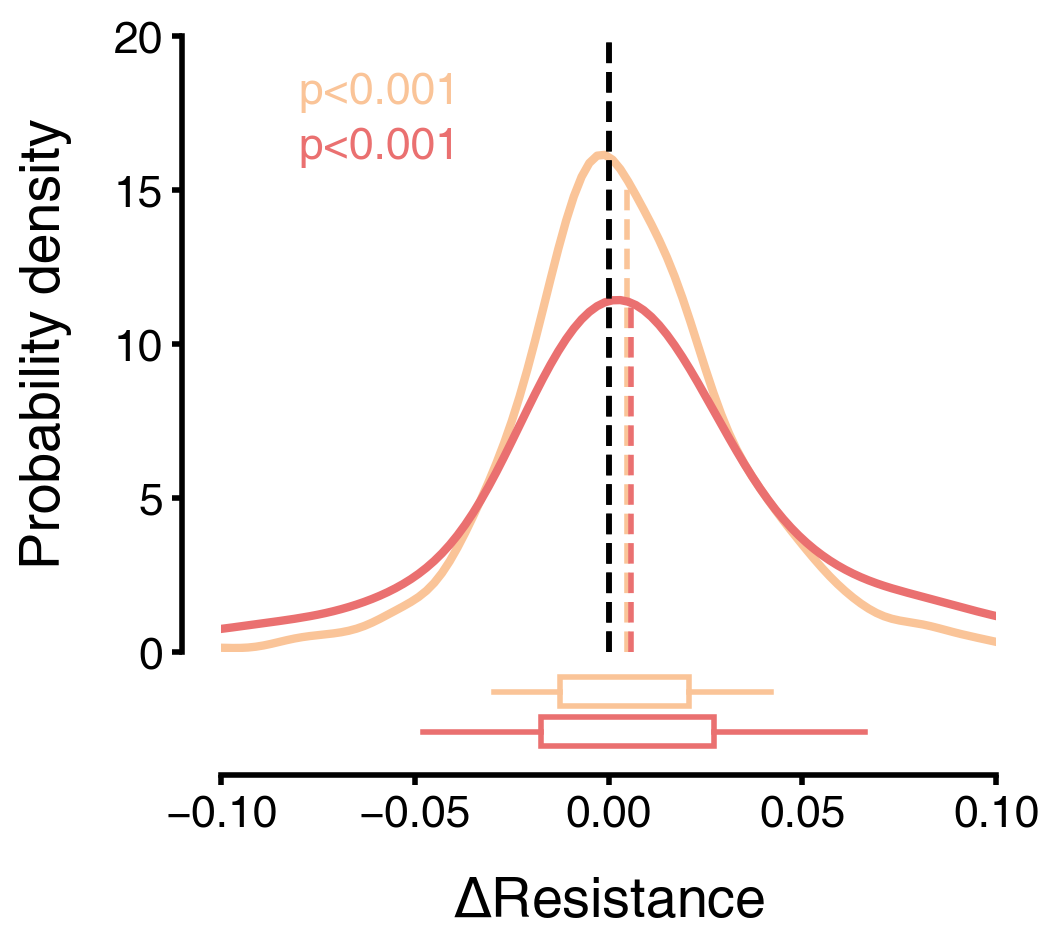

In [67]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl = np.array([(250,196,152),(234,112,112)])
cl2=cl/255
#cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)

for i in range(2):
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(df_delta[i])
    delta_rav=gc.nanravel(df_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)
    #label2=['NDVI'' {:.3f} ***'.format(mean),'CSIF'' {:.3f} ***'.format(mean)]
    ax.plot(x,z,lw=3,color=cl2[i])
    if p_delta[i]<0.001:
        #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
        ax.text(0.10,0.89-i*0.09, 'p<0.001', fontsize=16,transform = ax.transAxes,color=cl2[i])
    elif p_delta[i]<0.01:
        ax.text(0.10,0.89-i*0.1, 'p<0.01', fontsize=16,transform = ax.transAxes,color=cl2[i])
    elif p_delta[i]<0.08:
        ax.text(0.10,0.89-i*0.1, 'p<0.05', fontsize=16,transform = ax.transAxes,color=cl2[i])
    else:
        ax.text(0.10,0.89-i*0.1, 'p={:.2f}'.format(p_delta[i]), fontsize=16,transform = ax.transAxes,color=cl2[i])
    ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[i])
    ax.vlines(0,0,20,lw=2,ls='--',color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.legend(fontsize=12,loc='upper left',frameon=False)

#ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
ax=plt.gca()
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',-0.11))
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',-4))
ax.set_ylim(0,20)
ax.set_xlim(-0.1,0.1)
ax.set_xticks(np.arange(-0.1,0.11,0.05))
ax.set_yticks(np.arange(0,20.1,5))
ax.set_ylabel('Probability density',labelpad=15)
ax.set_xlabel('$\Delta$Resistance',labelpad=15)
ax.tick_params(labelsize=16)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i in range(2):
    if i ==0:
        ax1=fig.add_axes([0.122,-0.0,0.78,0.12])#左，底，宽，高
    if i==1:
        ax1=fig.add_axes([0.122,-0.05,0.78,0.12])#左，底，宽，高  
    ax1.set_xlim(-0.1,0.1)
    ax1.set_xticks(np.arange(-0.1,0.11,0.05))
    ax1.axis('off')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
    #ax.spines['bottom'].set_visible(False)
    bplot=ax1.boxplot(df_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':cl2[i],"markeredgecolor":cl2[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":cl2[i],"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl2[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl2[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl2[i],'color':cl2[i]})
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

## non-increased paired sites(0.25°)

In [16]:
#current shape:(6500,7900)
#0.01deg to 0.5 deg window size=2500 pixels
#6500/50,7900/50...(130,158)
def slide_window_mean(s,dist,res):
    # hold there are non NaN value in every para-arrays
    #s:window size
    #dist:disturb array
    #res:resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                mean_arr[i,j]=np.nan#calculate the mean value
                    #loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[ndvi_res,csif_res,dem,slope]
dist_name=['DEAA','DAA']
res_name=['ndvi_res','csif_res','dem','slope']

bb=[]
bb_name=[]
for i in range(2):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        bb.append(el)
        bb_name.append('Res_{}_{}_0.25deg_240402.npy'.format(dist_name[i],res_name[j]))
bb_name

['Res_DEAA_ndvi_res_0.25deg_240402.npy',
 'Res_DEAA_csif_res_0.25deg_240402.npy',
 'Res_DEAA_dem_0.25deg_240402.npy',
 'Res_DEAA_slope_0.25deg_240402.npy',
 'Res_DAA_ndvi_res_0.25deg_240402.npy',
 'Res_DAA_csif_res_0.25deg_240402.npy',
 'Res_DAA_dem_0.25deg_240402.npy',
 'Res_DAA_slope_0.25deg_240402.npy']

In [17]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(bb[i][0],bb[i][1],bb[i][2])
    np.save(spei_path+bb_name[i],kk)

执行任务0 (34392)...
执行任务1 (34392)...
执行任务2 (34392)...
执行任务3 (34392)...
执行任务4 (34392)...
执行任务5 (34392)...
执行任务6 (34392)...
执行任务7 (34392)...


## 成对样点求Δ

In [45]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Res_DEAA_dem_0.25deg_240402.npy',allow_pickle=True)
dem2=np.load(spei_path+'Res_DAA_dem_0.25deg_240402.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Res_DEAA_slope_0.25deg_240402.npy',allow_pickle=True)
slo2=np.load(spei_path+'Res_DAA_slope_0.25deg_240402.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [46]:
delta=[]
for i in range(2):
    f1=np.load(spei_path+'Res_DEAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Res_DAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [47]:
for i in range(2):
    print(res_name[i],"res count is",np.count_nonzero(~np.isnan(delta[i])))

ndvi_res res count is 619
csif_res res count is 618


In [48]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta[i]))

res_delta=list(map(list, zip(*res_delta)))#list转置
df_res_delta=pd.DataFrame(res_delta,columns=['ndvi_res','csif_res'])
df_res_delta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ndvi_res  618 non-null    float64
 1   csif_res  618 non-null    float64
dtypes: float64(2)
memory usage: 9.8 KB


In [49]:
print(np.std(df_res_delta['ndvi_res']),np.std(df_res_delta['csif_res']))
print(np.mean(df_res_delta['ndvi_res']),np.mean(df_res_delta['csif_res']))

0.022543078215051846 0.03735203865786844
0.0025466080622379835 0.003538249138875301


## Fig

### significants

In [50]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta=[]
for i in range(2):
    f1=np.load(spei_path+'Res_DEAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Res_DAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta.append(p)
p_delta

[0.0050967279984890515, 0.02617686009683399]

### fig_pdf

In [51]:
df_delta=[df_res_delta['ndvi_res'],df_res_delta['csif_res']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0025466080622379835 [21.8664867]
0.003538249138875301 [14.72049335]


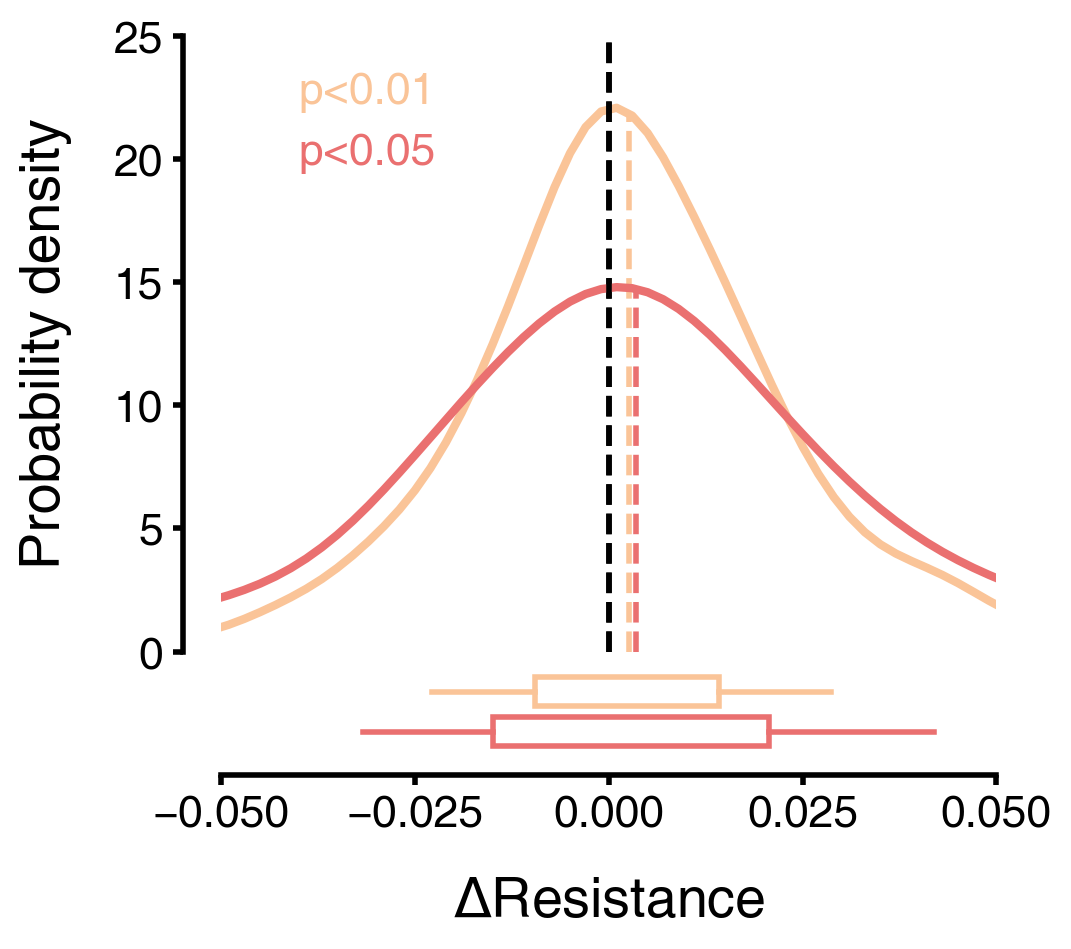

In [58]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl = np.array([(250,196,152),(234,112,112)])
cl2=cl/255
#cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)

for i in range(2):
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(df_delta[i])
    delta_rav=gc.nanravel(df_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)
    #label2=['NDVI'' {:.3f} ***'.format(mean),'CSIF'' {:.3f} ***'.format(mean)]
    ax.plot(x,z,lw=3,color=cl2[i])
    if p_delta[i]<0.001:
        #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
        ax.text(0.10,0.89-i*0.09, 'p<0.001', fontsize=16,transform = ax.transAxes,color=cl2[i])
    elif p_delta[i]<0.01:
        ax.text(0.10,0.89-i*0.1, 'p<0.01', fontsize=16,transform = ax.transAxes,color=cl2[i])
    elif p_delta[i]<0.08:
        ax.text(0.10,0.89-i*0.1, 'p<0.05', fontsize=16,transform = ax.transAxes,color=cl2[i])
    else:
        ax.text(0.10,0.89-i*0.1, 'p={:.2f}'.format(p_delta[i]), fontsize=16,transform = ax.transAxes,color=cl2[i])
    ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[i])
    ax.vlines(0,0,25,lw=2,ls='--',color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.legend(fontsize=12,loc='upper left',frameon=False)

#ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
ax=plt.gca()
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',-0.055))
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',-5))
ax.set_ylim(0,25)
ax.set_xlim(-0.05,0.05)
ax.set_xticks(np.arange(-0.05,0.051,0.025))
ax.set_yticks(np.arange(0,25.1,5))
ax.set_ylabel('Probability density',labelpad=15)
ax.set_xlabel('$\Delta$Resistance',labelpad=15)
ax.tick_params(labelsize=16)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i in range(2):
    if i ==0:
        ax1=fig.add_axes([0.122,-0.0,0.78,0.12])#左，底，宽，高
    if i==1:
        ax1=fig.add_axes([0.122,-0.05,0.78,0.12])#左，底，宽，高  
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.025))
    ax1.axis('off')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
    #ax.spines['bottom'].set_visible(False)
    bplot=ax1.boxplot(df_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':cl2[i],"markeredgecolor":cl2[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":cl2[i],"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl2[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl2[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl2[i],'color':cl2[i]})
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

# low_SPEI (2°)

## Low_SPEI data prepare

In [39]:
spei05='D:/Elephant_disturb/SPEI/'
spei_03 = spei05 + 'spei03.nc'
dt=Dataset(spei_03)
dt.variables.keys()

dict_keys(['lon', 'lat', 'time', 'spei'])

In [40]:
spei=dt.variables['spei']
#2012:(1332:1344),2013:(1344:1356),2014:(1356:1368),2015:(1368:1380),2016:(1380:1392)
spei2012_14=spei[1332:1368,:,:]
spei2015_16=spei[1368:1392,:,:]
spei_tot=[spei2012_14,spei2015_16]
for i in range(2):
    spei_tot[i][np.isnan(spei_tot[i])]=0
    spei_tot[i][spei_tot[i]>-1]=0
    spei_tot[i][spei_tot[i]<=-1]=1
np.nanmax(spei_tot[0])

1.0

In [42]:
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
spei_ev=np.zeros((2,360,720))
for k in range(2):
    dd=np.zeros((34,360,720))
    dd1=np.zeros((22,360,720))
    if k==0:
        for m in range(34):
            dd[m]=spei_tot[k][m]*spei_tot[k][m+1]*spei_tot[k][m+2] #连续3个月相乘，如果有1出现表示有连续3个月干旱
            spei_ev[k]=np.sum(dd,axis=0)
            spei_ev[k][spei_ev[k]>=1]=1
    if k==1:
        for m in range(22):
            dd1[m]=spei_tot[k][m]*spei_tot[k][m+1]*spei_tot[k][m+2] #连续3个月相乘，如果有1出现表示有连续3个月干旱
            spei_ev[k]=np.sum(dd1,axis=0)
            spei_ev[k][spei_ev[k]>=1]=1
    
spei_afr=spei_ev
print(spei_afr.shape)
spei_afr[np.isnan(spei_afr)]=0
spei_afr15_16=spei_afr[1]
spei_else=spei_afr[0]
#spei_else[spei_else>0]=1
spei1516_only=spei_afr15_16-spei_else
print(np.min(spei1516_only),np.max(spei1516_only))
spei1516_only[spei1516_only==-1]=0

(2, 360, 720)
-1.0 1.0


In [43]:
dt_dr=np.zeros((3,360, 720))
dt_dr[0]=spei_ev[0]
dt_dr[1]=spei_ev[1]
dt_dr[2]=spei1516_only

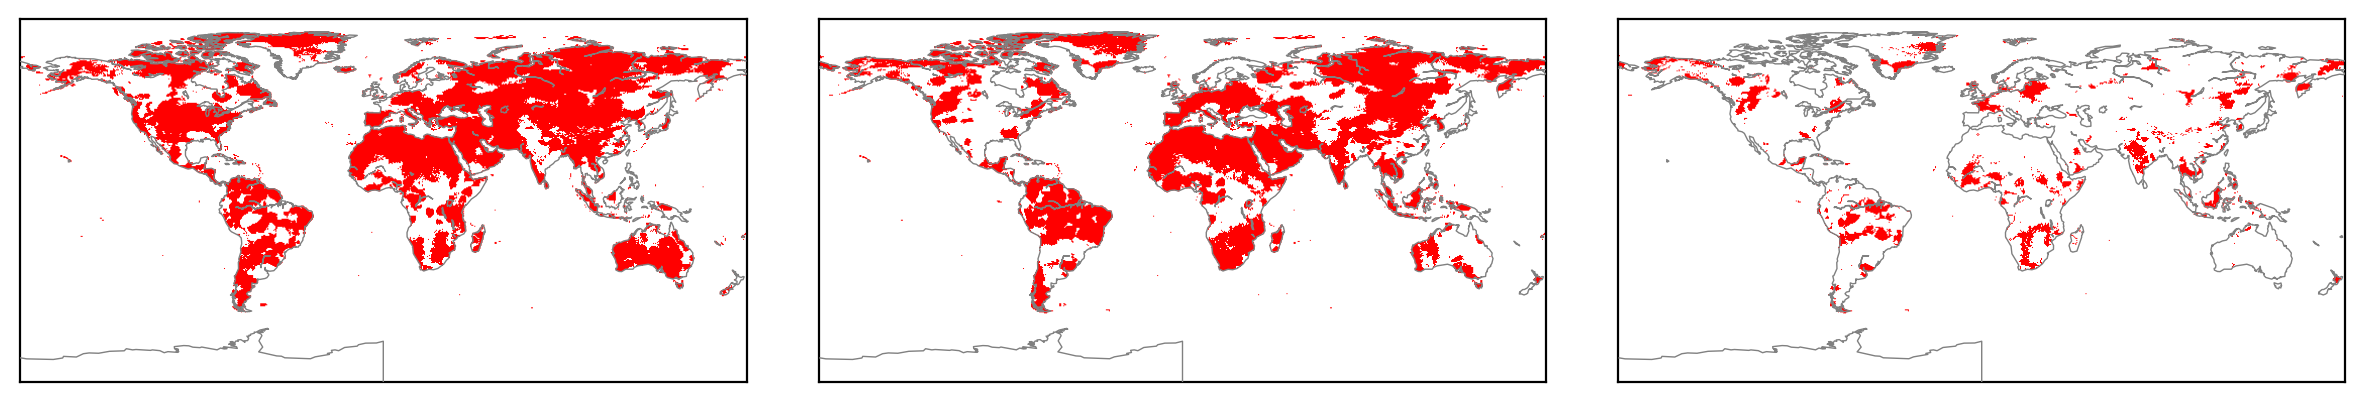

In [46]:
Lon=dt.variables['lon'][:]
Lat=dt.variables['lat'][:]
LonMin,LatMax,LonMax,LatMin = [Lon.min(),Lat.max(),Lon.max(),Lat.min()]
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5) 
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
lon1 = LonMin;lon2 = LonMax
lat1 = LatMin;lat2 = LatMax
fig = plt.figure(figsize=(15,5)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
    #m.drawmapboundary(linewidth=1,fill_color = 'lightcyan')
    m.drawcoastlines(linewidth=0.5, color='gray',zorder=40)
    clist=['white','red']
    cmp=LinearSegmentedColormap.from_list('chaos',clist)
    im = m.imshow(np.flip(dt_dr,1)[i],cmap =cmp,origin='upper')

#2012-2014年干旱区域，2015-2016年干旱区域，仅2015-2016年干旱区域

In [49]:
from osgeo import gdal,osr,ogr
spei_dt1=np.flip(dt_dr,1)[2]
Lon=dt.variables['lon'][:]
Lat=dt.variables['lat'][:]
LonMin,LatMax,LonMax,LatMin = [Lon.min(),Lat.max(),Lon.max(),Lat.min()] 
#分辨率计算
N_Lat = len(Lat) 
N_Lon = len(Lon)
Lon_Res = (LonMax - LonMin) /(float(N_Lon)-1)
Lat_Res = (LatMax - LatMin) / (float(N_Lat)-1)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326) # 定义输出的坐标系为"WGS 84"，AUTHORITY["EPSG","4326"]
proj=srs.ExportToWkt()
geotrans = (LonMin, Lon_Res, 0, LatMax, 0, Lat_Res)

def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
write_img(spei05+'SPEI_drought05.tif',proj,geotrans,spei_dt1)

In [50]:
#ENVI中resize to 0.01deg
#SPEI_drought05_sub_001.tif
gdal.Warp(spei05+'SPEI_drought05_sub_001_afr.tif',
          spei05+'SPEI_drought05_sub_001',
          dstSRS='EPSG:4326',
          outputBounds = [-26,-40,53,25],
          xRes=0.01,
          yRes=0.01,
          targetAlignedPixels=True,
          resampleAlg = gdalconst.GRA_NearestNeighbour,
          creationOptions = ["COMPRESS=LZW"])
drought=read_img(spei05+'SPEI_drought05_sub_001_afr.tif')[0]
drought.shape

(6500, 7900)

In [113]:
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
DEAA=drought*ele
DAA=drought-DEAA
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

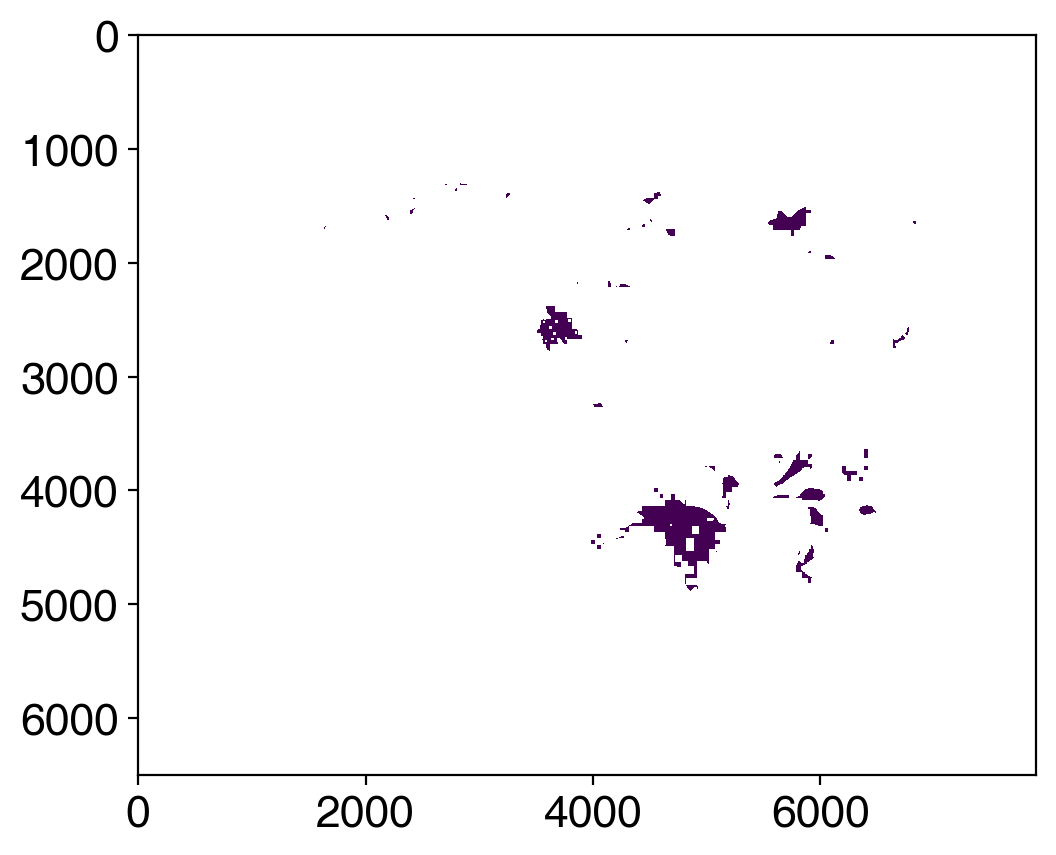

In [53]:
plt.imshow(DEAA)

## slide window

In [201]:
#current shape:(6500,7900)
#0.01deg to 2 deg window size=40000 pixels
#6500/50,7900/50...(130,158)
def slide_window_mean(s,dist,res):
    # hold there are non NaN value in every para-arrays
    #s:window size
    #dist:disturb array
    #res:resistance and resilience array
    mean_arr=np.zeros((32,39))
    weight_arr=np.zeros((32,39))
    loc=np.zeros((32,39)) #record the location of supplied sites
    sl=np.ones((200,200))
    for i in range(32):
        #print("sliding", i, "line...")
        for j in range(39):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/40000#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/40000)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    #loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    #loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[ndvi_res,csif_res,dem,slope]
dist_name=['DEAA','DAA']
res_name=['ndvi_res','csif_res','dem','slope']

bb=[]
bb_name=[]
for i in range(2):
    for j in range(4):
        el=[200,dist_pool[i],res_pool[j]]
        bb.append(el)
        bb_name.append('Res_low-SPEI_{}_{}_1deg_240402.npy'.format(dist_name[i],res_name[j]))
bb_name

['Res_low-SPEI_DEAA_ndvi_res_1deg_240402.npy',
 'Res_low-SPEI_DEAA_csif_res_1deg_240402.npy',
 'Res_low-SPEI_DEAA_dem_1deg_240402.npy',
 'Res_low-SPEI_DEAA_slope_1deg_240402.npy',
 'Res_low-SPEI_DAA_ndvi_res_1deg_240402.npy',
 'Res_low-SPEI_DAA_csif_res_1deg_240402.npy',
 'Res_low-SPEI_DAA_dem_1deg_240402.npy',
 'Res_low-SPEI_DAA_slope_1deg_240402.npy']

In [202]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(bb[i][0],bb[i][1],bb[i][2])
    np.save(spei_path+bb_name[i],kk)

执行任务0 (34392)...
执行任务1 (34392)...
执行任务2 (34392)...
执行任务3 (34392)...
执行任务4 (34392)...
执行任务5 (34392)...
执行任务6 (34392)...
执行任务7 (34392)...


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 成对样点求Δ

In [68]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Res_low-SPEI_DEAA_dem_1deg_240402.npy',allow_pickle=True)
dem2=np.load(spei_path+'Res_low-SPEI_DAA_dem_1deg_240402.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Res_low-SPEI_DEAA_slope_1deg_240402.npy',allow_pickle=True)
slo2=np.load(spei_path+'Res_low-SPEI_DAA_slope_1deg_240402.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((32,39))*dem_differ*slo_differ

In [69]:
delta=[]
for i in range(2):
    f1=np.load(spei_path+'Res_low-SPEI_DEAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Res_low-SPEI_DAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(32, 39)

In [70]:
for i in range(2):
    print(res_name[i],"res count is",np.count_nonzero(~np.isnan(delta[i])))

ndvi_res res count is 160
csif_res res count is 160


In [71]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta[i]))

res_delta=list(map(list, zip(*res_delta)))#list转置
df_res_delta=pd.DataFrame(res_delta,columns=['ndvi_res','csif_res'])
df_res_delta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ndvi_res  160 non-null    float64
 1   csif_res  160 non-null    float64
dtypes: float64(2)
memory usage: 2.6 KB


In [72]:
print(np.std(df_res_delta['ndvi_res']),np.std(df_res_delta['csif_res']))
print(np.mean(df_res_delta['ndvi_res']),np.mean(df_res_delta['csif_res']))

0.03859206653361008 0.0879091557392441
0.005803124606609344 0.004594820365309715


## Fig

### significants

In [73]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta=[]
for i in range(2):
    f1=np.load(spei_path+'Res_low-SPEI_DEAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Res_low-SPEI_DAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta.append(p)

### fig_pdf

In [74]:
df_delta=[df_res_delta['ndvi_res'],df_res_delta['csif_res']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.005803124606609344 [12.82992587]
0.004594820365309715 [7.12988236]


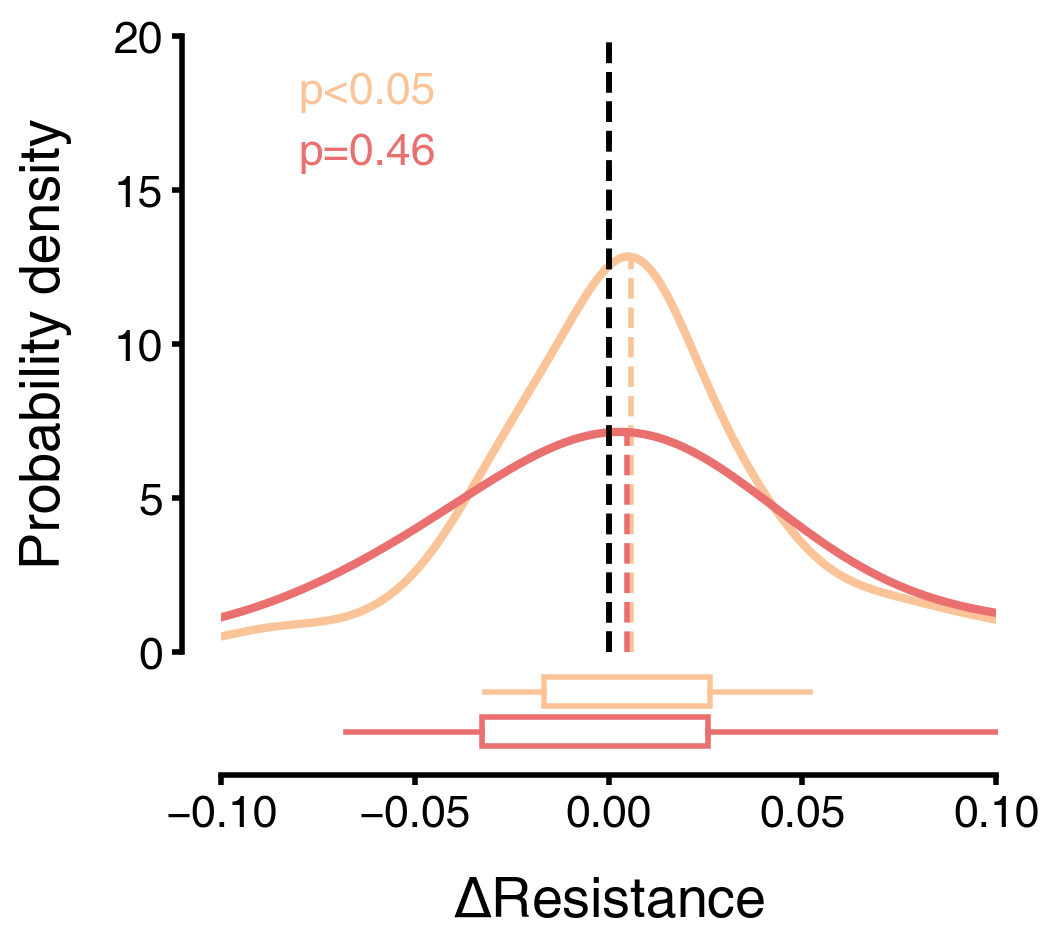

In [75]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl = np.array([(250,196,152),(234,112,112)])
cl2=cl/255
#cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)

for i in range(2):
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(df_delta[i])
    delta_rav=gc.nanravel(df_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)
    #label2=['NDVI'' {:.3f} ***'.format(mean),'CSIF'' {:.3f} ***'.format(mean)]
    ax.plot(x,z,lw=3,color=cl2[i])
    if p_delta[i]<0.001:
        #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
        ax.text(0.10,0.89-i*0.09, 'p<0.001', fontsize=16,transform = ax.transAxes,color=cl2[i])
    elif p_delta[i]<0.01:
        ax.text(0.10,0.89-i*0.1, 'p<0.01', fontsize=16,transform = ax.transAxes,color=cl2[i])
    elif p_delta[i]<0.08:
        ax.text(0.10,0.89-i*0.1, 'p<0.05', fontsize=16,transform = ax.transAxes,color=cl2[i])
    else:
        ax.text(0.10,0.89-i*0.1, 'p={:.2f}'.format(p_delta[i]), fontsize=16,transform = ax.transAxes,color=cl2[i])
    ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[i])
    ax.vlines(0,0,20,lw=2,ls='--',color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.legend(fontsize=12,loc='upper left',frameon=False)

#ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
ax=plt.gca()
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',-0.11))
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',-4))
ax.set_ylim(0,20)
ax.set_xlim(-0.1,0.1)
ax.set_xticks(np.arange(-0.1,0.11,0.05))
ax.set_yticks(np.arange(0,20.1,5))
ax.set_ylabel('Probability density',labelpad=15)
ax.set_xlabel('$\Delta$Resistance',labelpad=15)
ax.tick_params(labelsize=16)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

for i in range(2):
    if i ==0:
        ax1=fig.add_axes([0.122,-0.0,0.78,0.12])#左，底，宽，高
    if i==1:
        ax1=fig.add_axes([0.122,-0.05,0.78,0.12])#左，底，宽，高  
    ax1.set_xlim(-0.1,0.1)
    ax1.set_xticks(np.arange(-0.1,0.11,0.05))
    ax1.axis('off')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
    #ax.spines['bottom'].set_visible(False)
    bplot=ax1.boxplot(df_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':cl2[i],"markeredgecolor":cl2[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":cl2[i],"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl2[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl2[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl2[i],'color':cl2[i]})
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')